# La patogénesis del alzhéimer: clasificación precoz mediante redes neuronales
_**Objetivo:** distinguir a sujetos que puedan desarrollar alzhéimer con una exactitud superior al 65% y una antelación al diagnóstico de más de tres años._

_**Datos** del proyecto [OASIS 3](https://www.oasis-brains.org/)._

_**Entorno de desarrollo testado:** Dispositivo con procesador Apple M1. Software base: MacOS Monterey 12.5.1 con Miniconda y [Mamba](https://mamba.readthedocs.io/en/latest/installation.html) instalados_


### Tarea previa: obtener el listados de sesiones y diagnósticos
1. Pedir acceso en https://www.oasis-brains.org/#access
2. Esperar a la concesión
3. Crear un usuario mediante el mail de confirmación recibido
4. Acceder a la plataforma [XNAT](https://central.xnat.org/)
5. Identificarse
6. Abrir el proyecto OASIS3
7. Abrir la pestaña (tab) **MR Sessions**
8. Descargar fichero CSV en: Options > Spreadsheet
9. Colocar el fichero en el mismo directorio de este notebook
10. Abrir la pestaña (tab) **ADRC Clinical Data**
11. Descargar fichero CSV en: Options > Spreadsheet
12. Colocar el fichero en el mismo directorio de este notebook

### Instalar en entorno en Mamba con las dependencias necesarias
Se proporciona un fichero de entorno con todo lo necesario llamado `mamba_environment.yml`
Para tenerlo listo, ejecutar las siguientes sentencias en la línea de comandos:

    mamba env create tf -f mamba_environment.yml
    mamba activate tf

### Obtención de datos
Del CSV de sesiones decargado (aquí llamado `oasis3_mr_list.csv`), solo necesitamos los ID de las sesiones para la descarga de IRM.

In [1]:
import pandas as pd

dfMR = pd.read_csv('oasis3_mr_list.csv')
dfSessions = dfMR[['MR ID']]
dfSessions.to_csv('oasis3_sessions_list.csv', header=None, index=False)


Para la obtención de las IRM, se utilizan los scripts oficiales que nos ofrece la plataforma XNAT.

En este caso, se van a utilizar las IRM empleadas del tipo T1w. Recomendables 50 GB de espacio.

En línea de comandos (fuera de Python), ejecutar:

    git clone https://github.com/NrgXnat/oasis-scripts.git
    sudo chmod u+x ./oasis-scripts/download_scans/download_oasis_scans.sh
    ./oasis-scripts/download_scans/download_oasis_scans.sh oasis3_sessions_list.csv scans $USUARIO_XNAT T1w

> Reemplazar `$USUARIO_XNAT` por el usuario real.

### Estandarización y preparación de diagnósticos

In [2]:
dfDiagnostics = pd.read_csv('./oasis3_diagnostic_data.csv')
print(dfDiagnostics['dx1'].unique())

['Cognitively normal' 'uncertain dementia' 'Unc: ques. Impairment'
 'AD dem w/depresss- not contribut' 'AD Dementia'
 'AD dem distrubed social- with' 'AD dem w/CVD contribut'
 'Non AD dem- Other primary' 'AD dem visuospatial- with'
 'AD dem visuospatial- prior' 'AD dem Language dysf after' '.'
 'uncertain- possible NON AD dem' 'Vascular Demt- primary'
 'AD dem w/PDI after AD dem not contrib' '0.5 in memory only'
 'Incipient Non-AD dem' 'AD dem distrubed social- prior'
 'Frontotemporal demt. prim' 'AD dem distrubed social- after'
 'AD dem w/PDI after AD dem contribut' 'uncertain  possible NON AD dem'
 'AD dem w/depresss  not contribut' 'AD dem w/oth (list B) contribut'
 'DLBD- primary' 'Incipient demt PTP' 'Dementia/PD- primary'
 'AD dem w/depresss- contribut' 'Unc: impair reversible'
 'AD dem w/oth (list B) not contrib' 'AD dem w/CVD not contrib'
 'AD dem Language dysf prior' 'AD dem Language dysf with' 'DAT'
 'Vascular Demt  primary' 'DLBD- secondary'
 'AD dem w/oth unusual features' 

In [3]:
def getBinaryDiagnostic(diagnostic):
    lowerDiag = str(diagnostic).lower()

    if 'non ad' in lowerDiag:
        return 0
    if 'non-ad' in lowerDiag:
        return 0
    if 'ad dem cannot be primary' in lowerDiag:
        return 0
    if 'ad' in lowerDiag:
        return 1
    if 'dat' in lowerDiag:
        return 1
       
    return 0

dfDiagnostics['BinaryDiag'] = dfDiagnostics['dx1'].apply(getBinaryDiagnostic)

Interesa saber los días de diagnóstico de la EA.

In [4]:
dfDiagnostics['Day'] = dfDiagnostics['ADRC_ADRCCLINICALDATA ID'].str.split('_d').str[1].astype(int)
dfDiagnostics.head()

,ADRC_ADRCCLINICALDATA ID,Subject,Date,Age,mmse,ageAtEntry,cdr,commun,dx1,dx2,...,perscare,apoe,sumbox,acsparnt,height,weight,primStudy,acsStudy,BinaryDiag,Day
0,OAS30001_ClinicalData_d0000,OAS30001,NaN,NaN,28.0,65.149895,0.0,0.0,Cognitively normal,.,...,0.0,23.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0
1,OAS30001_ClinicalData_d0339,OAS30001,NaN,NaN,28.0,65.149895,0.0,0.0,Cognitively normal,.,...,0.0,23.0,0.0,NaN,64.0,155.0,NaN,NaN,0,339
2,OAS30001_ClinicalData_d0722,OAS30001,NaN,NaN,30.0,65.149895,0.0,0.0,Cognitively normal,.,...,0.0,23.0,0.0,NaN,64.0,162.0,NaN,NaN,0,722
3,OAS30001_ClinicalData_d1106,OAS30001,NaN,NaN,30.0,65.149895,0.0,0.0,Cognitively normal,.,...,0.0,23.0,0.0,NaN,64.0,167.0,NaN,NaN,0,1106
4,OAS30001_ClinicalData_d1456,OAS30001,NaN,NaN,30.0,65.149895,0.0,0.0,Cognitively normal,.,...,0.0,23.0,0.0,NaN,63.0,173.0,NaN,NaN,0,1456


### Preprocesamiento del df de aprendizaje

Solo necesitamos los casos de los que hayamos logrado descargar una IRM.

In [5]:
import os

downloadedScansIDs = pd.DataFrame(os.listdir('./scans/'), columns=['MR ID'])
print(f'{downloadedScansIDs.shape} vs {dfMR.shape}')

(2832, 1) vs (2844, 8)


In [6]:
dfMR = pd.merge(dfMR, downloadedScansIDs, on=['MR ID'])
dfMR.shape

(2831, 8)

Solo interesa el último diagnóstico de cada sujeto.

In [7]:
dfDiagnostics = dfDiagnostics.sort_values('ADRC_ADRCCLINICALDATA ID')
dfDiagnostics = dfDiagnostics.drop_duplicates('Subject', keep='last')

Se omiten las sesiones de los sujetos sin diagnóstico.

In [8]:
mrSubjectsSize = dfMR['Subject'].unique().size
diagnosticsSubjectsSize = dfDiagnostics['Subject'].unique().size
print(f'MR subjects: {mrSubjectsSize} vs Diagnosis subjects: {diagnosticsSubjectsSize}')

MR subjects: 1376 vs Diagnosis subjects: 1098


In [9]:
dfMR = dfMR.merge(dfDiagnostics, on=['Subject'])
dfMR['Subject'].unique().size

1098

Se omiten los atributos que no se tiene intención de utilizar o analizar.

In [10]:
dfMR = dfMR[['MR ID', 'Subject', 'Age_x', 'BinaryDiag', 'Day']]
dfMR = dfMR.rename(columns={'Age_x': 'Age'})

### Análisis descriptivo y visualizaciones iniciales

Text(0, 0.5, 'Número de sesiones')

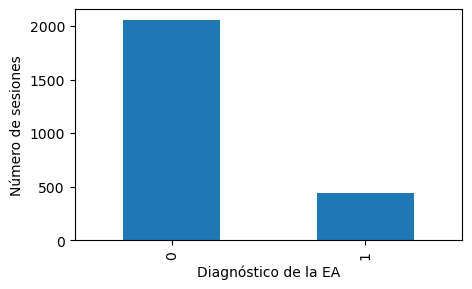

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 3]

dfMR['BinaryDiag'].value_counts().plot(kind='bar')
plt.xlabel('Diagnóstico de la EA')
plt.ylabel('Número de sesiones')

Se observa una clasificación de partida desbalanceada. Se optará por el sobremuestreo (al disponer de bastantes cortes en cada IRM).

Se visualiza y trata un muestra.

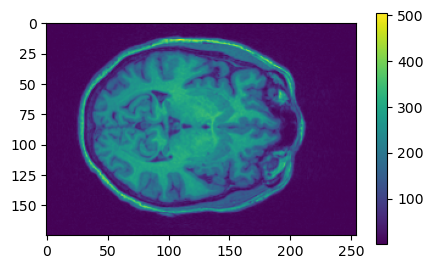

In [16]:
import nibabel as nib
import numpy as np
from skimage import transform

sample = nib.load('./scans/OAS30001_MR_d0129/anat2/sub-OAS30001_ses-d0129_run-01_T1w.nii.gz')
sampleData = sample.get_fdata()
sampleY, sampleX, sampleZ = sampleData.shape
halfCut = sampleZ // 2
sampleData = sampleData[:,:,halfCut]
sampleData = transform.resize(sampleData, (175, 255), order=1, preserve_range=True)

plt.imshow(sampleData)
plt.colorbar()

In [17]:
sampleData.shape

(175, 255)

In [18]:
min, max = sampleData.min(), sampleData.max()
print(f'Mínimo original: {min}. Máximo original: {max}')

Mínimo original: 0.00020168067226873177. Máximo original: 504.0775966386553


Es ideal normalizar la escala para hacer más eficiente el aprendizaje. Se plantea una estandarización positiva (entre 0 y 1).

In [19]:
from numpy import clip

def normalizeImageData(data):
    mean, std = data.mean(), data.std()
    standardData = (data - mean) / std
    standardData = clip(standardData, -1.0, 1.0)
    standardData = (standardData + 1.0) / 2.0

    return standardData

standardSampleData = normalizeImageData(sampleData)

min, max = standardSampleData.min(), standardSampleData.max()
print(f'Mínimo estándar: {min}. Máximo estándar: {max}')

Mínimo estándar: 0.05705619213177093. Máximo estándar: 1.0


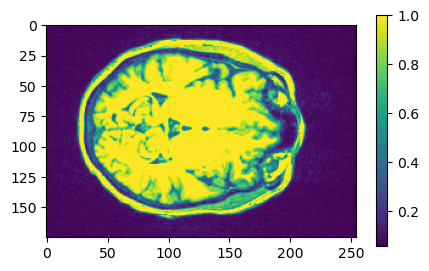

In [20]:
plt.imshow(standardSampleData)
plt.colorbar()

### Incorporación de IRM al df

Se cuadruplican los casos positivos para balancear el df.

In [21]:
def getNTimes(value):
    nTimes = 1
    if value == 1: nTimes = 4
    return nTimes

dfMR['NTimes'] = dfMR['BinaryDiag'].apply(getNTimes)
dfMR = dfMR.reindex(dfMR.index.repeat(dfMR['NTimes'])).reset_index(drop=True)
dfMR = dfMR.drop(columns={'NTimes'})
dfMR['BinaryDiag'].value_counts(normalize=True)

0    0.536534
1    0.463466
Name: BinaryDiag, dtype: float64

In [22]:
dfMR['Cut'] = dfMR.groupby(['MR ID']).cumcount()+1
dfMR['BinaryDiag'].value_counts(normalize=True)

0    0.536534
1    0.463466
Name: BinaryDiag, dtype: float64

Se incorporan las IRM al df.

- Se omiten las que tienen los planos en distino orden (se asume el último como el axial).
- Se normalizan
- Se fuerza su tamaño a 175x255

> Se propone como mejora la revisión de imágenes para incorporarlas todas.

In [23]:
cutOffset = {1: 0, 2: -5, 3: 5, 4: 10}

def getAxialCut(row):
    mrID, nCut = row['MR ID'], row['Cut']

    for dir, subdirs, files in os.walk(f'./scans/{mrID}'):
        for file in files:
            if file.endswith('.nii.gz'):
                print(f'Processing {mrID} cut {nCut}')
                image = nib.load(f'{dir}/{file}')
                imageData = image.get_fdata()

                imageY, imageX, imageZ = imageData.shape
                if imageZ < imageX: return

                cut = imageX // 2 + cutOffset[nCut]
                imageCut = imageData[:,:,cut]
                imageCut = normalizeImageData(imageCut)
                imageCut = transform.resize(imageCut, (175, 255), order=1, preserve_range=True)

                print(f'OK {mrID} ncut {nCut}')
                return imageCut
            break

dfMR['IRM'] = dfMR.apply(lambda row: getAxialCut(row), axis=1)

Processing OAS30001_MR_d0129 cut 1
OK OAS30001_MR_d0129 ncut 1
Processing OAS30001_MR_d0757 cut 1
OK OAS30001_MR_d0757 ncut 1
Processing OAS30001_MR_d2430 cut 1
OK OAS30001_MR_d2430 ncut 1
Processing OAS30001_MR_d3132 cut 1
OK OAS30001_MR_d3132 ncut 1
Processing OAS30001_MR_d3746 cut 1
OK OAS30001_MR_d3746 ncut 1
Processing OAS30001_MR_d4467 cut 1
OK OAS30001_MR_d4467 ncut 1
Processing OAS30002_MR_d0371 cut 1
OK OAS30002_MR_d0371 ncut 1
Processing OAS30002_MR_d0653 cut 1
OK OAS30002_MR_d0653 ncut 1
Processing OAS30002_MR_d2340 cut 1
OK OAS30002_MR_d2340 ncut 1
Processing OAS30003_MR_d0558 cut 1
OK OAS30003_MR_d0558 ncut 1
Processing OAS30003_MR_d2682 cut 1
OK OAS30003_MR_d2682 ncut 1
Processing OAS30003_MR_d3320 cut 1
OK OAS30003_MR_d3320 ncut 1
Processing OAS30003_MR_d4954 cut 1
OK OAS30003_MR_d4954 ncut 1
Processing OAS30004_MR_d1101 cut 1
OK OAS30004_MR_d1101 ncut 1
Processing OAS30004_MR_d2229 cut 1
OK OAS30004_MR_d2229 ncut 1
Processing OAS30004_MR_d2232 cut 1
OK OAS30004_MR_d2232

In [24]:
dfMR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3832 entries, 0 to 3831
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MR ID       3832 non-null   object 
 1   Subject     3832 non-null   object 
 2   Age         3400 non-null   float64
 3   BinaryDiag  3832 non-null   int64  
 4   Day         3832 non-null   int64  
 5   Cut         3832 non-null   int64  
 6   IRM         2173 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 209.7+ KB


In [25]:
dfMR.dropna(subset=['IRM'], inplace=True)
dfMR.reset_index(drop=True, inplace=True)
dfMR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2173 entries, 0 to 2172
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MR ID       2173 non-null   object 
 1   Subject     2173 non-null   object 
 2   Age         1960 non-null   float64
 3   BinaryDiag  2173 non-null   int64  
 4   Day         2173 non-null   int64  
 5   Cut         2173 non-null   int64  
 6   IRM         2173 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 119.0+ KB


Se vuelve a revisar la distribución de casos. Es adecuada por ser relativamente equitativa.

Text(0, 0.5, 'Número de sesiones')

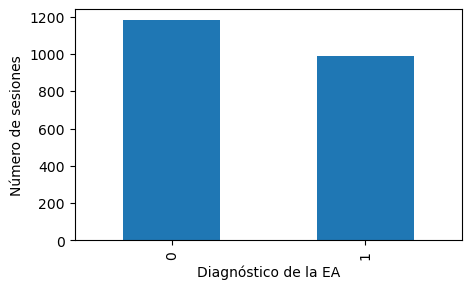

In [26]:
dfMR['BinaryDiag'].value_counts().plot(kind='bar')
plt.xlabel('Diagnóstico de la EA')
plt.ylabel('Número de sesiones')

In [27]:
dfMR

,MR ID,Subject,Age,BinaryDiag,Day,Cut,IRM
0,OAS30001_MR_d0129,OAS30001,65.0,0,3977,1,"[[0.08560876808106123, 0.07664706380586876, 0...."
1,OAS30001_MR_d0757,OAS30001,67.0,0,3977,1,"[[0.06254208016590311, 0.054417912302267654, 0..."
2,OAS30001_MR_d2430,OAS30001,71.0,0,3977,1,"[[0.13628387391846555, 0.1273744751212903, 0.1..."
3,OAS30001_MR_d3132,OAS30001,73.0,0,3977,1,"[[0.05013864924537897, 0.06588620930901747, 0...."
4,OAS30001_MR_d3746,OAS30001,NaN,0,3977,1,"[[0.14313008908162178, 0.14313008908162178, 0...."
...,...,...,...,...,...,...,...
2168,OAS31170_MR_d2410,OAS31170,71.0,1,3836,2,"[[0.07104370791492645, 0.08491888220128395, 0...."
2169,OAS31170_MR_d2410,OAS31170,71.0,1,3836,3,"[[0.05840332499062754, 0.058363974820864806, 0..."
2170,OAS31170_MR_d2410,OAS31170,71.0,1,3836,4,"[[0.07331324707332865, 0.07611774524339412, 0...."
2171,OAS31172_MR_d0407,OAS31172,72.0,0,3294,1,"[[0.05944883885340373, 0.059571961326406686, 0..."


Se visualiza una matriz de IRM con diversidad en casos.

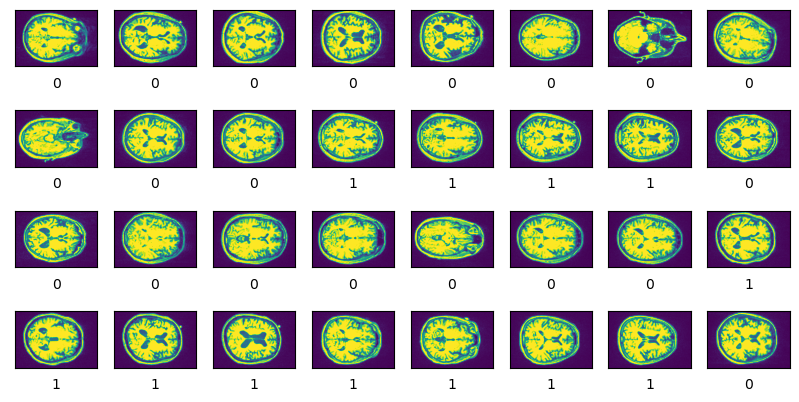

In [56]:
plt.figure(figsize=(10,5))
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(dfMR['IRM'][i+2140])
    plt.xlabel(dfMR['BinaryDiag'][i+2140])

### Aprendizaje

Se crean las series de aprendizaje y entrenamiento. 80% y 20% respectivamente.

In [63]:
from sklearn.model_selection import train_test_split

xValues = np.stack(np.array(dfMR['IRM']), axis=0)
yValues = np.array(dfMR['BinaryDiag'])

x_train, x_test, y_train, y_test = train_test_split(xValues, yValues, test_size=0.2)

In [66]:
xValues.shape

(2173, 175, 255)

Se define el modelo.

In [65]:
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(256, activation='relu', input_shape=(175, 255)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

